In [1]:
import math
import os

import cv2
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.layers import (AveragePooling2D, BatchNormalization,
                                     Concatenate, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling2D, Input,
                                     MaxPooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array, load_img)
from tensorflow.keras.utils import Sequence, to_categorical
from tqdm import tqdm

In [2]:
TRAIN_DIR = "../input/petfinder-pawpularity-score/train"
TEST_DIR = "../input/petfinder-pawpularity-score/test"
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3
BATCH_SIZE = 32
DENSE_FEATURES = [
    'Subject Focus',
    'Eyes',
    'Face',
    'Near',
    'Action',
    'Accessory',
    'Group',
    'Collage',
    'Human',
    'Occlusion',
    'Info',
    'Blur',
]
INCLUDE_DENSE_FEATURES = True
PATIENCE = 3

In [3]:
import pandas as pd

df_train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df_test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
df_train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


100%|██████████| 9912/9912 [02:19<00:00, 71.31it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'width'}>]], dtype=object)

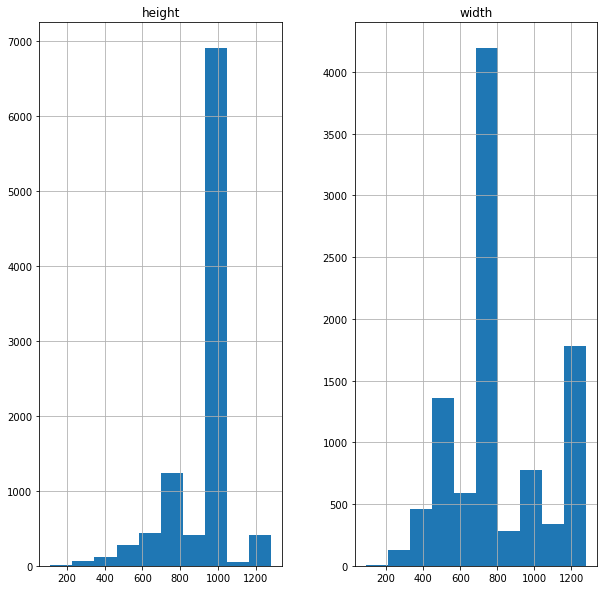

In [4]:
import matplotlib.pyplot as plt

def get_image_size_distribution():
    data = {"height": [], "width": []}
    for file in tqdm(os.listdir(TRAIN_DIR)):
        path = TRAIN_DIR + "/" + file
        image = cv2.imread(path)
        height, width, channels = image.shape
        data["height"].append(height)
        data["width"].append(width)
    return data

sizes = get_image_size_distribution()
df_distrib = pd.DataFrame(sizes)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
df_distrib.hist(ax=ax)

In [5]:
import math
from random import shuffle
import numpy as np

class PawpularDataset(Sequence):
    def __init__(self, df, subset, shuffle):
        self.subset = subset
        if subset in ["train", "validation"]:
            self.y = df.Pawpularity.tolist()
        elif subset == "test":
            self.y = []
        self.df = df
        self.ids = df.Id.tolist()
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.ids)/self.batch_size)

    def shuffle_samples(self):
        samples = list(zip(self.ids, self.y))
        shuffle(samples)
        self.ids, self.y = zip(*samples)
    
    def __getitem__(self, index):
        X = self.ids[index * self.batch_size: (index + 1) * self.batch_size]
        y = self.y[index * self.batch_size: (index + 1) * self.batch_size]

        return self.process_x_and_y(X, y)
    
    def load_image(self, path):
        return img_to_array(load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH)))
    
    def load_images(self, ids):
        if self.subset in ["train", "validation"]:
            paths = [f"{TRAIN_DIR}/{id_}.jpg" for id_ in ids]
        elif self.subset == "test":
            paths = [f"{TEST_DIR}/{id_}.jpg" for id_ in ids]
            
        return np.asarray([self.load_image(path) for path in paths])
                    
    def load_dense_features(self, ids):
        features = self.df[self.df.Id.isin(ids)]
        features = features[DENSE_FEATURES]
        
        return np.array(features.values).astype("float32")
    
    def process_x_and_y(self, X, y):
        images = self.load_images(X)
        if INCLUDE_DENSE_FEATURES:
            dense_features = self.load_dense_features(X)
            X = [images, dense_features]
        else:
            X = images
        if self.subset in ["train", "validation"]:
            y = tf.convert_to_tensor(y)
            return X, y
        elif self.subset == "test":
            return (X,)
            
    def on_epoch_end(self):
        if self.shuffle and self.subset == "train":
            self.shuffle_samples()

In [6]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(df_train, test_size=0.15)

train = PawpularDataset(shuffle=True, df=train, subset="train")
validation = PawpularDataset(shuffle=False, df=validation, subset="validation")
test = PawpularDataset(shuffle=False, df=df_test, subset="test")

In [7]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB5, EfficientNetB7

input_picture = Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
input_dense = Input(shape=(len(DENSE_FEATURES)))

model = EfficientNetB5(
    weights='../input/effnetsb0-b7-notops/efficientnetb5_notop.h5', 
    include_top=False, 
    input_tensor=input_picture)
model.trainable = False

x = GlobalAveragePooling2D()(model.output)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

concat_layer = Concatenate()([x, input_dense])
output = Dense(64)(concat_layer)
output = Dense(1)(output)
model = Model(inputs=[input_picture, input_dense], outputs=output)

2021-11-04 21:00:57.858707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 21:00:57.958940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 21:00:57.959748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 21:00:57.961523: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
opt = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=opt,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [9]:
model.fit(
    train,
    validation_data=validation,
    epochs=15,
    verbose=2,
    callbacks = [
        EarlyStopping('val_loss', mode='auto', patience=PATIENCE, restore_best_weights=True)],
)

2021-11-04 21:01:08.645533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-11-04 21:01:21.544698: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


264/264 - 222s - loss: 440.2276 - root_mean_squared_error: 20.9816 - val_loss: 341.4128 - val_root_mean_squared_error: 18.4774
Epoch 2/15
264/264 - 200s - loss: 354.8766 - root_mean_squared_error: 18.8382 - val_loss: 332.7867 - val_root_mean_squared_error: 18.2424
Epoch 3/15
264/264 - 198s - loss: 356.9582 - root_mean_squared_error: 18.8933 - val_loss: 374.5835 - val_root_mean_squared_error: 19.3542
Epoch 4/15
264/264 - 199s - loss: 343.1516 - root_mean_squared_error: 18.5244 - val_loss: 402.6001 - val_root_mean_squared_error: 20.0649
Epoch 5/15
264/264 - 197s - loss: 339.3805 - root_mean_squared_error: 18.4223 - val_loss: 342.1189 - val_root_mean_squared_error: 18.4965


In [10]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=opt,
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

In [11]:
unfreeze_model(model)
model.fit(
    train,
    validation_data=validation,
    epochs=15,
    verbose=2,
    callbacks = [
        EarlyStopping('val_loss', mode='auto', patience=PATIENCE, restore_best_weights=True)],
)

Epoch 1/15
264/264 - 214s - loss: 318.4719 - root_mean_squared_error: 17.8458 - val_loss: 322.5530 - val_root_mean_squared_error: 17.9598
Epoch 2/15
264/264 - 199s - loss: 295.3559 - root_mean_squared_error: 17.1859 - val_loss: 321.3173 - val_root_mean_squared_error: 17.9253
Epoch 3/15
264/264 - 200s - loss: 270.1840 - root_mean_squared_error: 16.4373 - val_loss: 328.1748 - val_root_mean_squared_error: 18.1156
Epoch 4/15
264/264 - 200s - loss: 251.0007 - root_mean_squared_error: 15.8430 - val_loss: 329.1305 - val_root_mean_squared_error: 18.1420
Epoch 5/15
264/264 - 199s - loss: 235.2272 - root_mean_squared_error: 15.3371 - val_loss: 326.7129 - val_root_mean_squared_error: 18.0752


In [12]:
predictions = model.predict(test)
df_test["Pawpularity"] = predictions
df_test = df_test[["Id", "Pawpularity"]]
df_test.to_csv("submission.csv", index=False)